# Прогнозирование температуры звезды

## Загрузка данных

In [1]:
# установка дополнительных пакетов
!pip install optuna skorch

You should consider upgrading via the '/home/troflianin/.pyenv/versions/3.8.12/envs/jupyter/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import random
import warnings
from math import sqrt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import optuna
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.dataset import ValidSplit 
from skorch import NeuralNetRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [3]:
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

SEED = 123

In [4]:
stars = pd.read_csv('/datasets/6_class.csv')

In [5]:
def get_info(df):
    display(df.shape)
    display(df.head())
    display(df.info())
    display(df.describe())
    display(df.isna().sum())

In [6]:
get_info(stars)

(240, 7)

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


None

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,119.50000,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,69.42622,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,0.00000,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,59.75000,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,119.50000,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,179.25000,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,239.00000,40000.000000,849420.000000,1948.500000,20.060000,5.000000


Unnamed: 0                0
Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

**Описание данных:**
- абсолютная температура T(K) — температура на поверхности звезды в Кельвинах;
- относительная светимость L/Lo — светимость звезды относительно Солнца;
- относительный радиус R/Ro — радиус звезды относительно радиуса Солнца;
- абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды;
- тип звезды;
- звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.

**Вывод:** датасет с характеристиками изученных звезд состоит из 240 строк и 7 столбцов. Есть столбец `Unnamed: 0` - его нужно удалить. По полученной первичной информации пропусков не обнаружено, требуется переименование столбцов для лучшего восприятия, типы данных преобразовывать не нужно. По описательным статистикам, на первый взгляд, наблюдаются аномальные значения, чтобы их исследовать необходимо визуализировать данные.
Столбцы `Star type` и `Star color` - категориальные - данные в них необходимо категоризовать для обучения модели, столбцы `Luminosity(L/Lo)`, `Radius(R/Ro)`, `Absolute magnitude(Mv)` - количественные, значения нужно масштабировать.

## Предобработка данных

In [7]:
# удаление столбца Unnamed: 0
stars = stars.drop('Unnamed: 0', axis=1)

In [8]:
# переименование столбцов
stars = stars.rename({
    'Temperature (K)': 'temperature',
    'Luminosity(L/Lo)': 'luminosity',
    'Radius(R/Ro)': 'radius',
    'Absolute magnitude(Mv)': 'absolute_magnitude',
    'Star type': 'star_type',
    'Star color': 'star_color'
}, axis=1)

In [9]:
stars.columns

Index(['temperature', 'luminosity', 'radius', 'absolute_magnitude',
       'star_type', 'star_color'],
      dtype='object')

In [10]:
# проверка на явные дубликаты
stars.duplicated().sum()

0

In [11]:
# проверка на уникальные значения столбца с цветом звезды
stars['star_color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

В столбце с цветом звезды есть строки с пробелами в конце, дубликаты из-за разного регистра и дефисы. Приведу все строки к нижнему регистру, избавлюсь от пробельных символов и заменю дефисы в наименовании цвета на пробелы.

In [12]:
stars['star_color'] = stars['star_color'].str.strip().str.lower().str.replace('-', ' ')
stars['star_color'] = stars['star_color'].replace('white yellow', 'yellow white')

In [13]:
stars['star_color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'whitish', 'yellow white', 'orange',
       'yellowish', 'orange red'], dtype=object)

In [14]:
# количество значений каждого цвета
stars['star_color'].value_counts()

red                   112
blue                   56
blue white             41
white                  10
yellow white            9
yellowish white         3
yellowish               3
whitish                 2
orange                  2
pale yellow orange      1
orange red              1
Name: star_color, dtype: int64

In [15]:
# удалю цвета с малым количеством значений
stars = stars.loc[stars['star_color'].isin(['red','blue','blue white','white','yellow white'])]

In [16]:
# проверка
stars['star_color'].value_counts()

red             112
blue             56
blue white       41
white            10
yellow white      9
Name: star_color, dtype: int64

## Исследовательский анализ данных

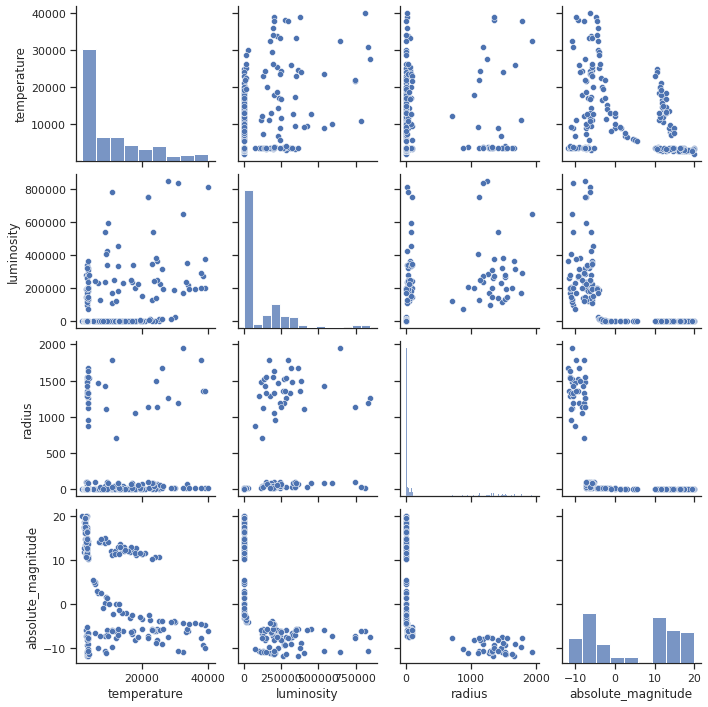

In [17]:
# парные графики для числовых признаков
sns.set_theme(style='ticks')

df = sns.load_dataset('penguins')
sns.pairplot(stars[['temperature', 'luminosity', 'radius', 'absolute_magnitude']])

In [18]:
# линейная корреляция признаков
stars[['temperature', 'luminosity', 'radius', 'absolute_magnitude']].corr().style.background_gradient()

,temperature,luminosity,radius,absolute_magnitude
temperature,1.000000,0.419711,0.074845,-0.433396
luminosity,0.419711,1.000000,0.494683,-0.692119
radius,0.074845,0.494683,1.000000,-0.603236
absolute_magnitude,-0.433396,-0.692119,-0.603236,1.000000


*Вывод:*
- между светимостью и абсолютной звёздной величиной наблюдается отрицательная зависимость: чем меньше звездная величина звезды, тем она ярче;
- линейной зависимости между радиусом и температурой нет

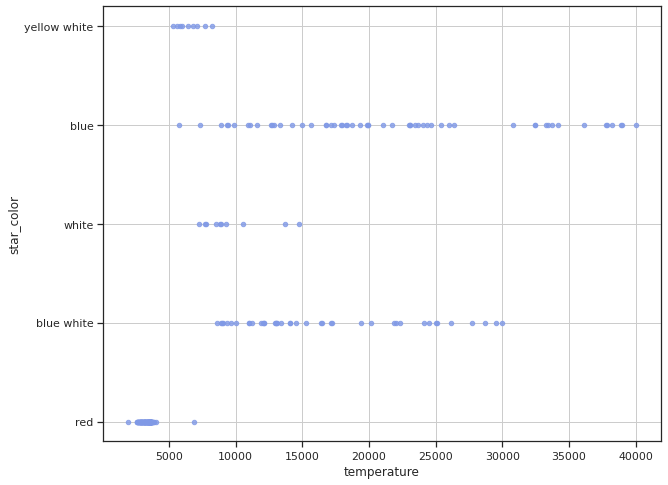

In [19]:
# график зависимости цвета звезды от температуры
color = np.array([.5, .6, .9])

stars.plot(
    kind='scatter', y='star_color', x='temperature', 
    grid=True, alpha=0.8, figsize=(10,8), c=np.atleast_2d(color)
)
ax = plt.gca()

*Вывод:* самые горячие звезды всегда голубого и бело-голубого цвета, менее горячие - желтоватого цвета, холодные - красного цвета.

Поскольку температура звезды зависит от ее цвета, построю диаграмму размаха, сгруппировав по цвету звезды с распределением температуры:

In [20]:
plt.rcParams['figure.figsize'] = [9, 9]
sns.set_theme(style="whitegrid")

<AxesSubplot:xlabel='temperature', ylabel='star_color'>

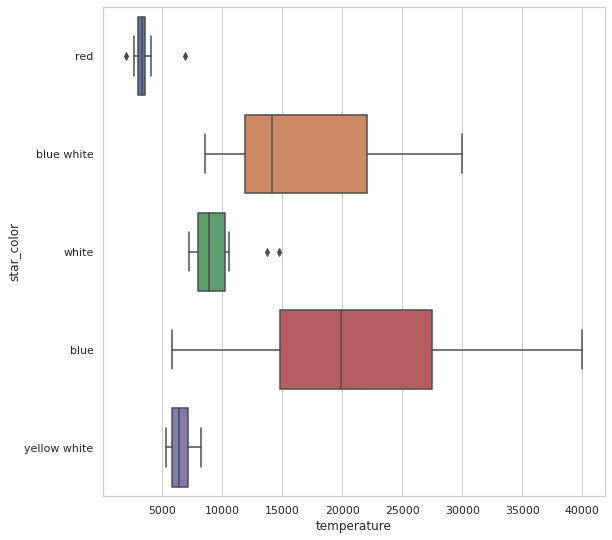

In [21]:
sns.boxplot(data=stars, x="temperature", y="star_color")

На диаграмме видны 2 выброса в группе с цветом `red` и 2 выброса в группе с цветом `white`. Поскольку это малый процент данных, удалю такие строки.

In [22]:
stars = stars[~((stars['star_color'] == 'white') & (stars['temperature'] > 12000))]
stars = stars[~((stars['star_color'] == 'red') & ((stars['temperature'] > 5000) | (stars['temperature'] < 2500)))]

In [23]:
stars.shape

(224, 6)

- ***исследование признака типа звезды `star_type`:***

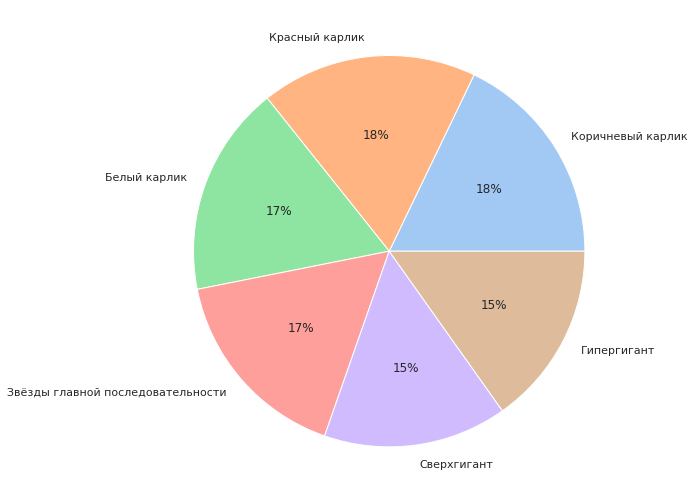

In [24]:
data = stars['star_type'].value_counts()
labels = [
    'Коричневый карлик', 'Красный карлик', 
    'Белый карлик', 'Звёзды главной последовательности',
    'Сверхгигант', 'Гипергигант'
]

colors = sns.color_palette('pastel')[:6]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

*Анализ:* после предобработки датасета и удаления некоторых строк процентное соотношение типов звезд приблизительно одинаковое.

- ***исследование признака цвета звезды `star_color`:***

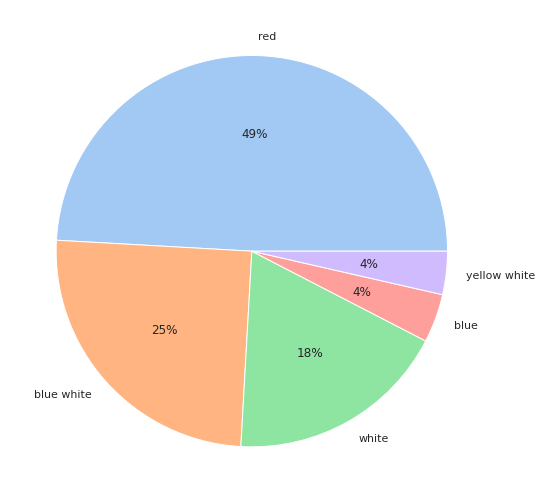

In [25]:
data = stars['star_color'].value_counts()
labels = stars['star_color'].unique()

colors = sns.color_palette('pastel')[:8]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

*Анализ:* после удаления малочисленных групп цветов осталось 5 цветов, звезд красного цвета - половина в датасете.

- ***исследование целевого признака `temperature`***

Text(0.5, 1.0, 'Histogram of temperature in kelvins')

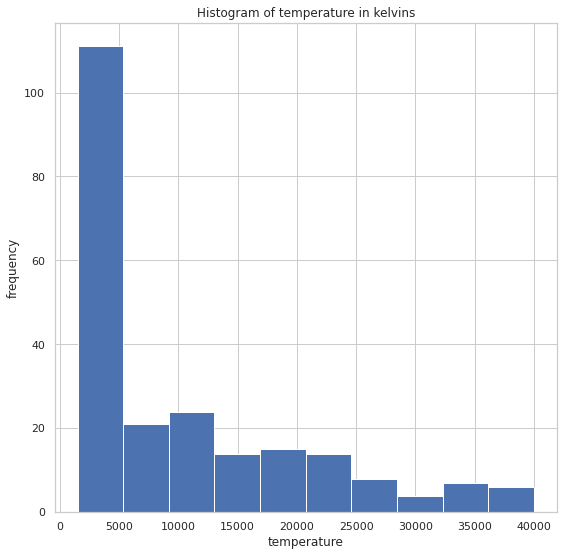

In [26]:
stars['temperature'].hist(range=(1500, 40000))
plt.xlabel('temperature')
plt.ylabel('frequency')
plt.title('Histogram of temperature in kelvins')

*Анализ графика:* температура половины исследованных звезд не превышала 5 000 Кельвинов. Также наблюдаются и звезды с температурой более 15 000 Кельвинов, хотя 75% значений температуры лежит до 15 000 Кельвинов. Такие данные не буду считать за выбросы, поскольку значение температуры не распределеяется равномерно и может иметь различные значения.

- ***исследование признака относительной светимости звезды `luminosity`:***

Text(0.5, 1.0, 'Histogram of luminosity')

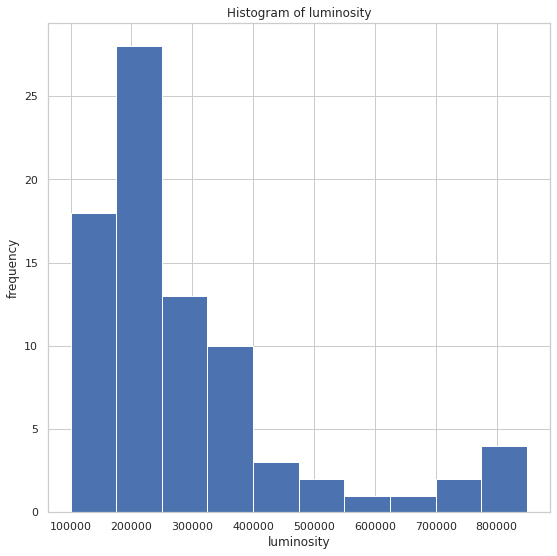

In [27]:
stars['luminosity'].hist(range=(100000, 850000))
plt.xlabel('luminosity')
plt.ylabel('frequency')
plt.title('Histogram of luminosity')

*Анализ графика:* светимостью звезды называют полную энергию, излучаемую в единицу времени. Измеряется либо в абсолютных единицах - Вт, либо в единицах светимости Солнца. Относительная величина показывает, во сколько раз светимость звезды больше или меньше светимости Солнца. Солнце не обладает максимальной светимостью относительно видимых звезд, а это значит что светимость ярких звезд может в миллионы раз превышать светимость Солнца. Поэтому, аномальных значений в распределении данного признака не выявлено.

- ***исследование признака относительного радиуса звезды `radius`:***

Text(0.5, 1.0, 'Histogram of radius')

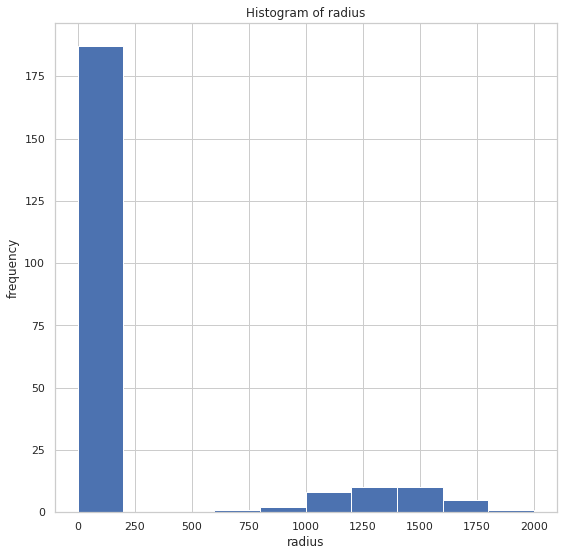

In [28]:
stars['radius'].hist(range=(0, 2000))
plt.xlabel('radius')
plt.ylabel('frequency')
plt.title('Histogram of radius')

<AxesSubplot:xlabel='radius'>

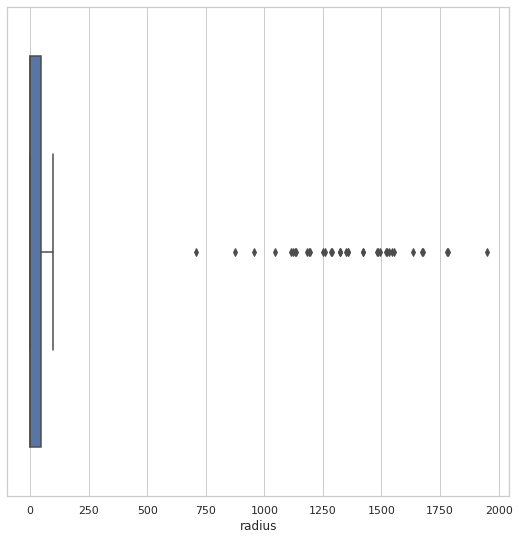

In [29]:
sns.boxplot(stars['radius'])

*Анализ графика:* по диаграмме размаха наблюдаются аномально большие значения, и их достаточно много. Возможно, в числе исследованных звезд в абсерватории встречались звезды очень большого радиуса, поэтому я не буду принимать такие данные за выбросы и оставлю их в датасете.

- ***исследование признака абсолютной звездной величины `absolute_magnitude`:***

Text(0.5, 1.0, 'Histogram of absolute magnitude')

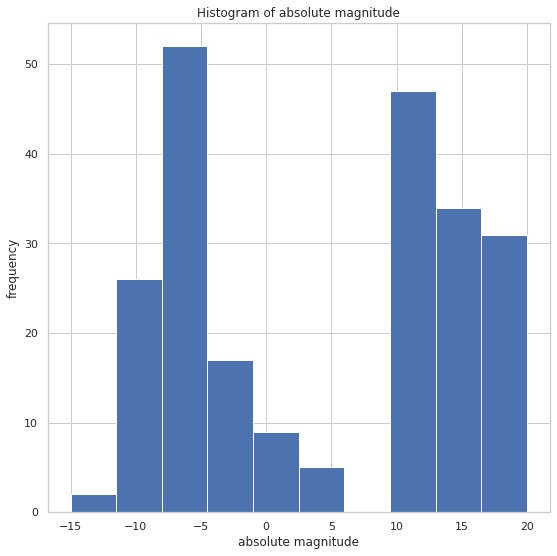

In [30]:
stars['absolute_magnitude'].hist(range=(-15, 20))
plt.xlabel('absolute magnitude')
plt.ylabel('frequency')
plt.title('Histogram of absolute magnitude')

<AxesSubplot:xlabel='absolute_magnitude'>

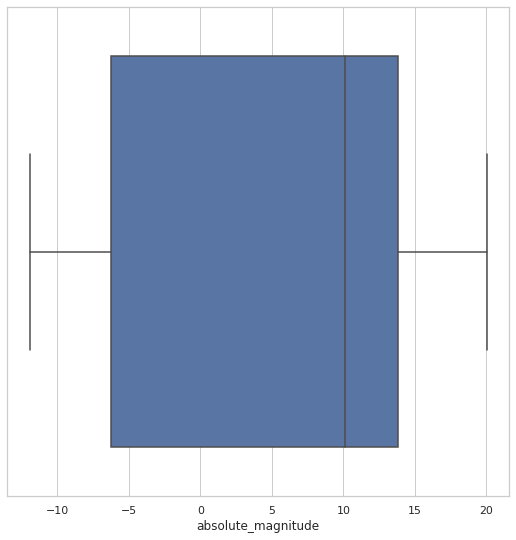

In [31]:
sns.boxplot(stars['absolute_magnitude'])

*Анализ графика:* абсолютной звездной величиной считается числовая безразмерная величина, характеризирующая яркость звезды по отношению к видимой площади. Положительное значение говорит о яркости звезды, отрицательное - о тусклости. Аномалий в распределении данного признака не наблюдается.

***Вывод по разделу:*** в процессе исследования я разобралась с природой данных, изучила характеристики звезд и их зависимости. Мне удалось обнаружить 4 выброса в данных и удалить их из датасета, а также избавиться от дубликатов в названии цвета звезды.

## Подготовка данных к построению модели

### Разделение данных на выборки

In [32]:
features = stars.drop(['temperature'], axis=1)
target = stars['temperature']

In [33]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.3, shuffle=True, random_state=SEED, stratify=stars['star_type']
)

In [34]:
# размеры полученных выборок
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(156, 5)
(156,)
(68, 5)
(68,)


### Масштабирование количественных признаков

In [35]:
numeric_columns = ['luminosity', 'radius', 'absolute_magnitude']

In [36]:
scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(features_train[numeric_columns])
features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])

In [37]:
display(features_train.head())
display(features_test.head())

,luminosity,radius,absolute_magnitude,star_type,star_color
173,3.720186e-01,0.861688,0.088291,5,blue
16,1.954275e-09,0.000078,0.836255,1,red
225,2.646276e-01,0.023604,0.139950,4,blue
45,3.767276e-01,0.014879,0.166562,4,red
126,8.594100e-10,0.000044,0.901691,0,red


,luminosity,radius,absolute_magnitude,star_type,star_color
114,1.554002e-01,0.781113,0.033187,5,red
224,2.904688e-01,0.031815,0.174389,4,blue
104,1.318547e-01,0.006154,0.188165,4,blue
123,1.177274e-11,0.000044,0.902943,0,red
217,1.285583e-02,0.003090,0.276769,3,blue white


### Кодирование категориальных признаков

In [38]:
cat_columns = ['star_type', 'star_color']

- обучающая выборка:

In [39]:
features_train_encoder = features_train.loc[:]

encoder = OneHotEncoder(handle_unknown='error', drop='first')
encoder.fit(features_train_encoder[cat_columns])
features_train_encoded = encoder.transform(features_train_encoder[cat_columns]).toarray()
features_train_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

In [40]:
features_train_df = pd.DataFrame(
    features_train_encoded, 
    columns=encoder.get_feature_names(cat_columns),
    index=features_train.index
)
features_train_df.head()

,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue white,star_color_red,star_color_white,star_color_yellow white
173,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
225,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
45,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
126,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [41]:
features_train_drop = features_train.drop(cat_columns, axis=1)
features_train_drop.head()

,luminosity,radius,absolute_magnitude
173,3.720186e-01,0.861688,0.088291
16,1.954275e-09,0.000078,0.836255
225,2.646276e-01,0.023604,0.139950
45,3.767276e-01,0.014879,0.166562
126,8.594100e-10,0.000044,0.901691


In [42]:
features_train_ohe = pd.concat((features_train_drop, features_train_df), axis=1)
features_train_ohe.head()

,luminosity,radius,absolute_magnitude,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue white,star_color_red,star_color_white,star_color_yellow white
173,3.720186e-01,0.861688,0.088291,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16,1.954275e-09,0.000078,0.836255,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
225,2.646276e-01,0.023604,0.139950,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
45,3.767276e-01,0.014879,0.166562,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
126,8.594100e-10,0.000044,0.901691,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


- тестовая выборка:

In [43]:
features_test_encoder = features_test.loc[:]
features_test_encoded = encoder.transform(features_test_encoder[cat_columns]).toarray()

In [44]:
features_test_df = pd.DataFrame(
    features_test_encoded, 
    columns=encoder.get_feature_names(cat_columns),
    index=features_test.index
)
features_test_df.head()

,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue white,star_color_red,star_color_white,star_color_yellow white
114,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
224,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
104,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
123,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
217,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [45]:
features_test_drop = features_test.drop(cat_columns, axis=1)
features_test_drop.head()

,luminosity,radius,absolute_magnitude
114,1.554002e-01,0.781113,0.033187
224,2.904688e-01,0.031815,0.174389
104,1.318547e-01,0.006154,0.188165
123,1.177274e-11,0.000044,0.902943
217,1.285583e-02,0.003090,0.276769


In [46]:
features_test_ohe = pd.concat((features_test_drop, features_test_df), axis=1)
features_test_ohe.head()

,luminosity,radius,absolute_magnitude,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue white,star_color_red,star_color_white,star_color_yellow white
114,1.554002e-01,0.781113,0.033187,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
224,2.904688e-01,0.031815,0.174389,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
104,1.318547e-01,0.006154,0.188165,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
123,1.177274e-11,0.000044,0.902943,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
217,1.285583e-02,0.003090,0.276769,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [47]:
display(features_train_ohe.head())
display(features_test_ohe.head())

,luminosity,radius,absolute_magnitude,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue white,star_color_red,star_color_white,star_color_yellow white
173,3.720186e-01,0.861688,0.088291,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16,1.954275e-09,0.000078,0.836255,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
225,2.646276e-01,0.023604,0.139950,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
45,3.767276e-01,0.014879,0.166562,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
126,8.594100e-10,0.000044,0.901691,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


,luminosity,radius,absolute_magnitude,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue white,star_color_red,star_color_white,star_color_yellow white
114,1.554002e-01,0.781113,0.033187,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
224,2.904688e-01,0.031815,0.174389,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
104,1.318547e-01,0.006154,0.188165,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
123,1.177274e-11,0.000044,0.902943,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
217,1.285583e-02,0.003090,0.276769,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


## Построение базовой нейронной сети

In [48]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

In [49]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')

In [50]:
features_train = torch.FloatTensor(features_train_ohe.values)
features_test = torch.FloatTensor(features_test_ohe.values)
target_train = torch.FloatTensor(target_train.values)
target_test = torch.FloatTensor(target_test.values)

In [175]:
class CustomEarlyStopping():
    def __init__(self, patience=5, min_delta=0):

        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if issubclass(type(val_loss), torch.Tensor):
            val_loss = val_loss.item()
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print('INFO: Early stopping.', f'delta={self.best_loss - val_loss}')
                self.early_stop = True

In [176]:
# задаю количество нейронов на входном и выходном слое
n_in_neurons = features_train_ohe.shape[1]
n_out_neurons = 1 

# задаю количество скрытых слоев и число нейронов в них
hidden_layers = [18, 20, 15, 10, 8, 4]

In [177]:
class NeuralNet(nn.Sequential): 
    def __init__(self, n_in_neurons, hidden_layers, n_out_neurons): 
        net_layers = [] 
        net_layers.append(nn.Linear(n_in_neurons, hidden_layers[0])) 
        # для входного слоя применяю функцию активации ReLU 
        net_layers.append(nn.ReLU()) 
         
        for i in range(1, len(hidden_layers)): 
            net_layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i])) 
            # для скрытых слоев применяю функцию активации ReLU 
            net_layers.append(nn.ReLU()) 
         
        net_layers.append(nn.Linear(hidden_layers[-1], n_out_neurons)) 
        # для выходного применяю функцию активации ReLU 
        net_layers.append(nn.ReLU()) 
         
        super().__init__(*net_layers)

In [192]:
net = NeuralNet(n_in_neurons=n_in_neurons, hidden_layers=hidden_layers, n_out_neurons=n_out_neurons)

net.apply(init_weights)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
early_stopping = CustomEarlyStopping(patience=100, min_delta=2)

loss = nn.L1Loss() 

num_epochs = 4000
loss_values_train = []
loss_values_test = []
epoche_numbers = []

for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()
    preds = net.forward(features_train).flatten()
        
    loss_train = loss(preds, target_train)
        
    loss_train.backward()
    optimizer.step()
    
    epoche_numbers.append(epoch)
    RMSE_train = sqrt(mean_squared_error(target_train.detach().numpy(), preds.detach().numpy()))
    with torch.no_grad():
        net.eval()
        test_preds = net.forward(features_test).flatten()
        loss_test = loss(test_preds, target_test)
        RMSE_test = mean_squared_error(target_test.detach().numpy(), test_preds.detach().numpy(), squared=False)
        loss_values_train.append(loss_train.item())
        loss_values_test.append(loss_test.item())
        
    early_stopping(RMSE_test)
    if early_stopping.early_stop:
        break
        
    if epoch % 300 == 0 or epoch == num_epochs:
        print(
            f'Эпоха: {epoch}, Значение функции потерь: {loss_train.item():.2f}',
            f'RMSE на обучающей выборке: {RMSE_train:.2f}'
        )
        
test_preds = net.forward(features_test)
RMSE_test = sqrt(mean_squared_error(target_test.detach().numpy(), test_preds.detach().numpy()))
print(f'RMSE на тестовой выборке: {RMSE_test:.2f}')

Эпоха: 0, Значение функции потерь: 10933.78 RMSE на обучающей выборке: 14822.84
Эпоха: 300, Значение функции потерь: 6128.00 RMSE на обучающей выборке: 10068.56
Эпоха: 600, Значение функции потерь: 4404.45 RMSE на обучающей выборке: 7765.16
Эпоха: 900, Значение функции потерь: 3592.99 RMSE на обучающей выборке: 6241.38
Эпоха: 1200, Значение функции потерь: 2306.26 RMSE на обучающей выборке: 4262.03
Эпоха: 1500, Значение функции потерь: 2223.54 RMSE на обучающей выборке: 4091.43
Эпоха: 1800, Значение функции потерь: 2183.48 RMSE на обучающей выборке: 4011.08
INFO: Early stopping. delta=-10.02099609375
RMSE на тестовой выборке: 4949.99


***Вывод*** 

Я обучила базовую модель нейронной сети, итоговое значение метрики удалось достичь со следующей архитектурой сети:
- нейронная сеть полносвязная;
- на входном слое 12 нейронов - по числу признаков:
- на выходном слое 1 нейрон, так как целевая переменная представлена в количественной шкале и решается задача регрессии;
- количество скрытых слоев - 6 и с количеством нейронов на них 18, 20, 15, 10, 8, 4 соответственно;
- на входном и скрытых слоях - функция активации ReLU;
- веса инициализированы равномерным распределением;
- функция потерь - среднее абсолютное отклонение L1Loss.

В качестве оптимизатора параметров модели я взяла Adam. Число эпох обучения я подобрала с помощью EarlyStopping и оно равно 1800.

**RMSE baseline на обучающей выборке: 4011.08, на тестовой - 4949.99.**

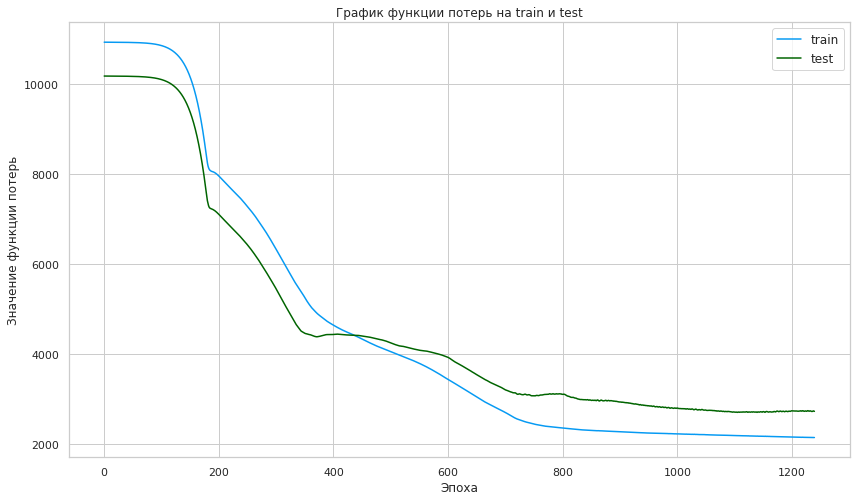

In [145]:
# построю график лосса на трейне и на тесте
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(
    epoche_numbers, loss_values_train, label='train', color='#069af3'
)
ax.plot(
    epoche_numbers, loss_values_test, label='test', color='#006400'
)
plt.xlabel('Эпоха')
plt.ylabel('Значение функции потерь')
plt.title('График функции потерь на train и test')
ax.legend(['train', 'test'], fontsize='medium')

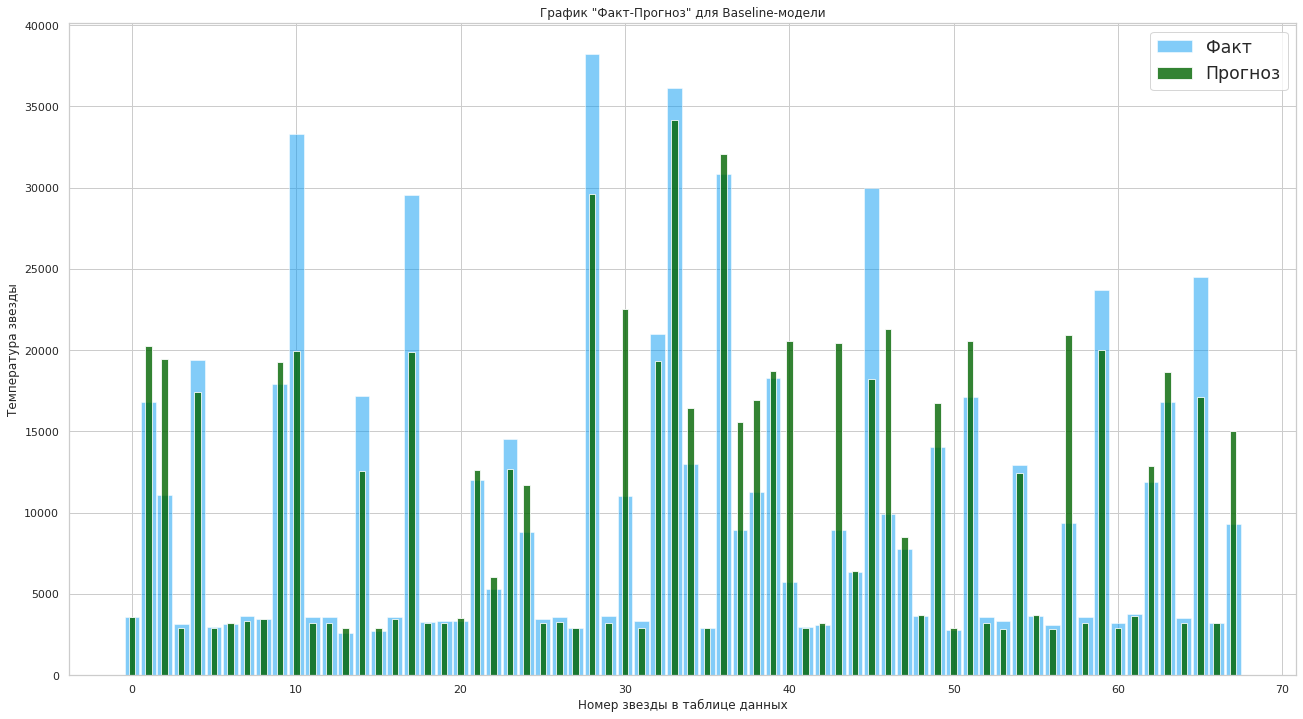

In [148]:
# график фактической температуры и предсказания модели
fig, ax = plt.subplots(figsize=(22,12))
ax.bar(
    range(len(target_test)), target_test, label='target', alpha=0.5, width=0.9, color='#069af3'
)
ax.bar(
    range(len(target_test)), np.hstack(test_preds.detach().numpy()),
    label='predicted', alpha=0.8, width=0.4, color='#006400'
)
plt.xlabel('Номер звезды в таблице данных')
plt.ylabel('Температура звезды')
plt.title('График "Факт-Прогноз" для Baseline-модели')
ax.legend(['Факт', 'Прогноз'], fontsize='x-large')

*Анализ графика:* график прогноза модели и фактического значения температуры наглядно показывает на каких данных и на сколько градусов ошибается модель: при фактической температуре звезды менее 5000 Кельвинов модель с наименьшей ошибкой делает предсказание, при температуре более 10000 Кельвинов значение ошибки модели сильно больше.

## Улучшение нейронной сети

In [149]:
class StarsDataset(Dataset):
    def __init__(self, features, target):
        self.features = features
        self.target = target
    
    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        target_row = self.target[idx]
        features_row = self.features[idx]
        sample = {"data": features_row, "temp": target_row}
        return sample

dataset_train = StarsDataset(features_train, target_train)
dataset_test = StarsDataset(features_test, target_test)

In [150]:
class NeuralNetNormalized(nn.Sequential): 
    def __init__(self, n_in_neurons, hidden_layers, n_out_neurons, normalize=False, dropout_value=0): 
        net_layers = [] 
        net_layers.append(nn.Linear(n_in_neurons, hidden_layers[0])) 
        # для входного слоя применяю функцию активации ReLU 
        net_layers.append(nn.ReLU())
        if normalize:
            net_layers.append(nn.BatchNorm1d(hidden_layers[0]))
        if dropout_value:
            net_layers.append(nn.Dropout(dropout_value))
         
        for i in range(1, len(hidden_layers)): 
            net_layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            # для скрытых слоев применяю функцию активации ReLU 
            net_layers.append(nn.ReLU())
            if normalize:
                net_layers.append(nn.BatchNorm1d(hidden_layers[i]))
            if dropout_value:
                net_layers.append(nn.Dropout(dropout_value))
         
        net_layers.append(nn.Linear(hidden_layers[-1], n_out_neurons)) 
        # для выходного применяю функцию активации ReLU 
        net_layers.append(nn.ReLU()) 
         
        super().__init__(*net_layers)

In [151]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

rmse_scorer = make_scorer(rmse) 

In [152]:
def objective(trial):
    # normalize = trial.suggest_categorical('normalize', [True, False])
    # dropout
    dropout_value = trial.suggest_float('dropout_value', 0.0, 0.3, step=0.1)

    #learning rate
    lr = trial.suggest_loguniform('learning_rate', 1e-6, 1e-0)
    
    #batch size 
    batch_size = trial.suggest_int('batch_size', 5, 120,  step=5)
    
    net_norm = NeuralNetNormalized(
        n_in_neurons=n_in_neurons, hidden_layers=hidden_layers, n_out_neurons=n_out_neurons, dropout_value=dropout_value
    )
    net_norm.apply(init_weights)
    
    patience = trial.suggest_int('patience', 20, 200, step=20)
    
    skorch_regressor = NeuralNetRegressor(
        module=net_norm, 
        device='cpu',  
        verbose=0,
        batch_size=batch_size,
        optimizer=torch.optim.Adam, 
        max_epochs=2700, 
        lr=lr,
        train_split=ValidSplit(cv=5, random_state=SEED),
        criterion =nn.L1Loss,
        callbacks=[
            ('val_rmse', EpochScoring(scoring=rmse_scorer, lower_is_better=True, name='RMSE')),
            ('estoper', EarlyStopping(lower_is_better=True, monitor='RMSE', patience=patience)),
        ],
    )
    
    

    rmse = cross_val_score(
        skorch_regressor, features_train.numpy().astype('float32'), 
        target_train.numpy().astype('float32').reshape(-1,1), 
        n_jobs=-1, 
        cv=5,
        scoring=rmse_scorer
    )
    rmse = abs(rmse.mean())
    return rmse

In [153]:
%%time
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300)

[I 2022-09-17 09:44:35,260] A new study created in memory with name: no-name-3db3800b-52ad-4578-9b11-99774605d290
[I 2022-09-17 09:44:52,380] Trial 0 finished with value: 7186.0734375 and parameters: {'dropout_value': 0.3, 'learning_rate': 0.0003925475837670573, 'batch_size': 120, 'patience': 180}. Best is trial 0 with value: 7186.0734375.
[I 2022-09-17 09:44:56,675] Trial 1 finished with value: 14728.7861328125 and parameters: {'dropout_value': 0.2, 'learning_rate': 1.4588620906904935e-06, 'batch_size': 20, 'patience': 20}. Best is trial 0 with value: 7186.0734375.
[I 2022-09-17 09:45:02,095] Trial 2 finished with value: 6484.728515625 and parameters: {'dropout_value': 0.2, 'learning_rate': 0.0016691981319421519, 'batch_size': 25, 'patience': 20}. Best is trial 2 with value: 6484.728515625.
[I 2022-09-17 09:45:03,219] Trial 3 finished with value: 14105.1642578125 and parameters: {'dropout_value': 0.3, 'learning_rate': 0.36404178019155997, 'batch_size': 95, 'patience': 100}. Best is tr

CPU times: user 13.4 s, sys: 400 ms, total: 13.8 s
Wall time: 33min 15s


In [154]:
study.best_trial.values

[4649.52255859375]

In [155]:
best_params = study.best_trial.params
best_params

{'dropout_value': 0.1,
 'learning_rate': 0.004949503297973507,
 'batch_size': 15,
 'patience': 200}

**Лучшие параметры: {'dropout_value': 0.1,
 'learning_rate': 0.004949503297973507,
 'batch_size': 15,
 'patience': 200}**

# Тестирование

In [194]:
net_norm = NeuralNetNormalized(
    n_in_neurons=n_in_neurons, hidden_layers=hidden_layers, n_out_neurons=n_out_neurons, 
    normalize=False, dropout_value=best_params['dropout_value']
)

net_norm.apply(init_weights)

optimizer = torch.optim.Adam(
    net_norm.parameters(), lr=best_params['learning_rate']
)

loss = nn.L1Loss()

batch_size = best_params['batch_size']
train_dataloader = DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True, num_workers=1
)
test_dataloader = DataLoader(
    dataset_test, batch_size=batch_size, num_workers=1
)

early_stopping = CustomEarlyStopping(patience=best_params['patience'], min_delta=2)
num_epochs = 2700

loss_values_train = []
loss_values_test = []
epoche_numbers = []

for epoch in range(num_epochs):
    net_norm.train()
    loss_train_sum = 0
    loss_test_sum = 0
    rmse_train_sum = 0
    rmse_test_sum = 0
    
    for batch in train_dataloader:
        X_batch = batch['data']
        y_batch = batch['temp']

        optimizer.zero_grad()
        preds = net_norm.forward(X_batch).flatten()
        
        loss_train = loss(preds, y_batch)
        loss_train.backward()
        optimizer.step()
        
        RMSE_train = sqrt(mean_squared_error(y_batch.detach().numpy(), preds.detach().numpy()))
        
        loss_train_sum += loss_train.item()
        rmse_train_sum += RMSE_train
    
    with torch.no_grad():
        net_norm.eval()
        for batch in test_dataloader:
            X_batch = batch['data']
            y_batch = batch['temp']
            test_preds = net_norm.forward(X_batch).flatten()
            loss_test_sum += loss(test_preds, y_batch).item()
            RMSE_test = mean_squared_error(y_batch.detach().numpy(), test_preds.detach().numpy(), squared=False)
            rmse_test_sum += RMSE_test

    epoche_numbers.append(epoch)
    loss_test = loss_test_sum / len(test_dataloader)
    loss_train = loss_train_sum / len(train_dataloader)
    loss_values_train.append(loss_train)
    loss_values_test.append(loss_test)
    if epoch % 100 == 0 or epoch == num_epochs:
        print(
            f'Эпоха: {epoch}, Значение функции потерь: {loss_train:.2f}',
            f'RMSE на обучающей выборке: {rmse_train_sum / len(train_dataloader):.2f}'
        )
        
    early_stopping(rmse_test_sum / len(test_dataloader))
    if early_stopping.early_stop:
        break

test_preds = net_norm.forward(features_test)
RMSE_test = sqrt(mean_squared_error(target_test.detach().numpy(), test_preds.detach().numpy()))
print(f'RMSE на тестовой выборке: {RMSE_test:.2f}')

Эпоха: 0, Значение функции потерь: 10740.54 RMSE на обучающей выборке: 14188.24
Эпоха: 100, Значение функции потерь: 3317.04 RMSE на обучающей выборке: 5278.44
Эпоха: 200, Значение функции потерь: 3393.24 RMSE на обучающей выборке: 5328.45
Эпоха: 300, Значение функции потерь: 3479.18 RMSE на обучающей выборке: 5244.48
Эпоха: 400, Значение функции потерь: 2958.86 RMSE на обучающей выборке: 4734.89
Эпоха: 500, Значение функции потерь: 3204.77 RMSE на обучающей выборке: 5359.22
Эпоха: 600, Значение функции потерь: 3488.35 RMSE на обучающей выборке: 5889.64
Эпоха: 700, Значение функции потерь: 3430.04 RMSE на обучающей выборке: 5437.19
Эпоха: 800, Значение функции потерь: 3131.89 RMSE на обучающей выборке: 5446.65
Эпоха: 900, Значение функции потерь: 3174.36 RMSE на обучающей выборке: 5702.93
INFO: Early stopping. delta=-221.11733398437536
RMSE на тестовой выборке: 4371.22


***Вывод:*** удалось достичь значения метрики **RMSE на тестовой выборке: 4371.22.** 
Этот результат оказался лучшим в процессе оптимизации модели. Наилучшие параметры с optuna:
- Dropout - 0.1;
- learning_rate - 0.004949503297973507;
- batch_size - 15;
- patience - 200.

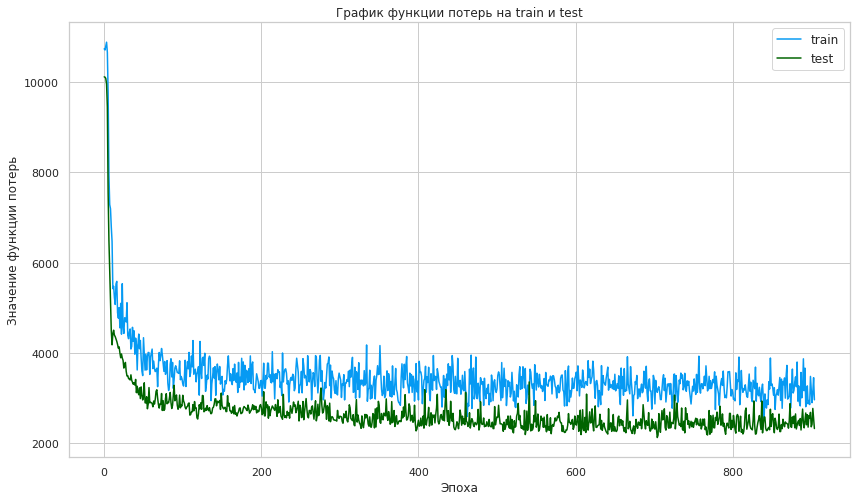

In [195]:
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(
    epoche_numbers, loss_values_train, label='train', color='#069af3'
)
ax.plot(
    epoche_numbers, loss_values_test, label='test', color='#006400'
)
plt.xlabel('Эпоха')
plt.ylabel('Значение функции потерь')
plt.title('График функции потерь на train и test')
ax.legend(['train', 'test'], fontsize='medium')

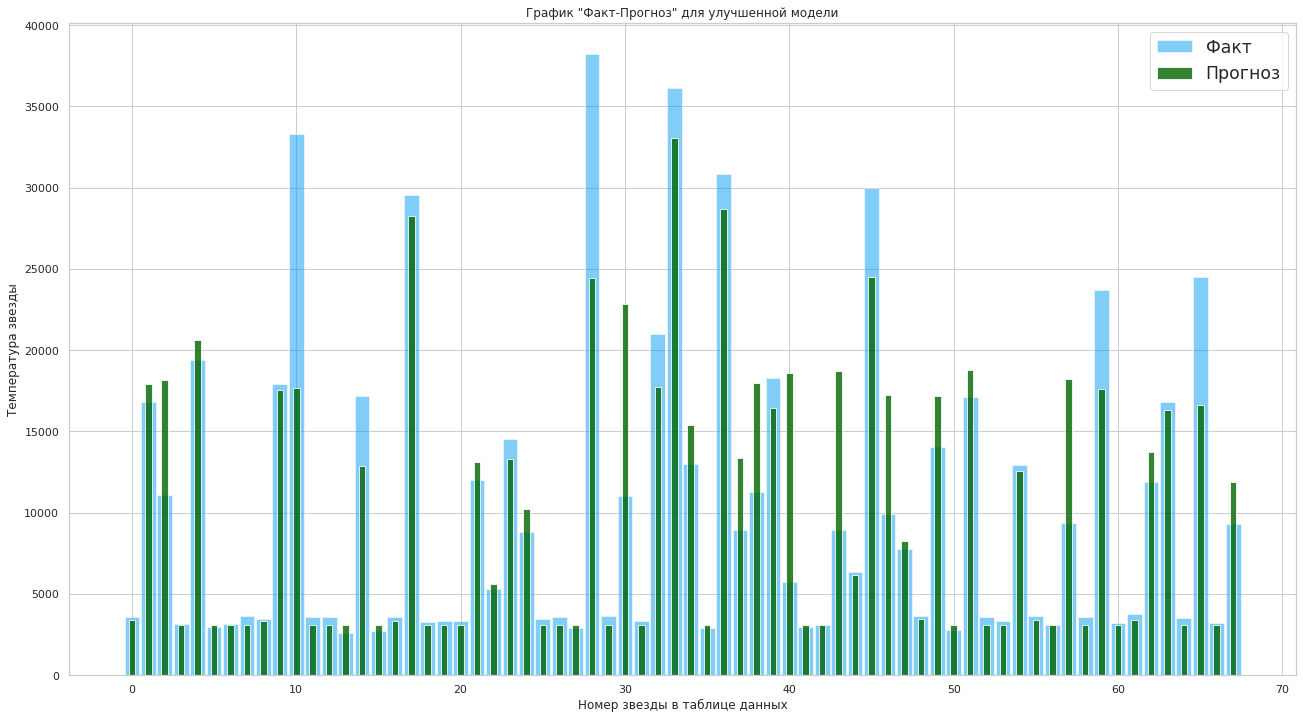

In [196]:
fig, ax = plt.subplots(figsize=(22,12))
ax.bar(
    range(len(target_test)), target_test, label='target', alpha=0.5, width=0.9, color='#069af3'
)
ax.bar(
    range(len(target_test)), np.hstack(test_preds.detach().numpy()),
    label='predicted', alpha=0.8, width=0.4, color='#006400'
)
plt.xlabel('Номер звезды в таблице данных')
plt.ylabel('Температура звезды')
plt.title('График "Факт-Прогноз" для улучшенной модели')
ax.legend(['Факт', 'Прогноз'], fontsize='x-large')

*Анализ графика:* график прогноза модели и фактического значения температуры для улучшенной модели не сильно отличается от графика для базовой: при фактической температуре звезды менее 5000 Кельвинов модель с наименьшей ошибкой делает предсказание, при температуре более 10000 Кельвинов значение ошибки модели сильно больше.

## Выводы

Были обучены две модели нейронной сети: базовая и с улучшением. Архитектура нейронной сети:
- нейронная сеть полносвязная;
- на входном слое 12 нейронов - по числу признаков:
- на выходном слое 1 нейрон, так как целевая переменная представлена в количественной шкале и решается задача регрессии;
- количество скрытых слоев - 6 и с количеством нейронов на них 18, 20, 15, 10, 8, 4 соответственно;
- на входном и скрытых слоях - функция активации ReLU;
- веса инициализированы равномерным распределением;
- функция потерь - среднее абсолютное отклонение L1Loss.

В качестве оптимизатора параметров модели я взяла Adam. Число эпох обучения я подобрала с помощью EarlyStopping и оно равно 1800.

Метрика RMSE у baseline: на обучающей выборке - 4011.08, на тестовой - 4949.99.

С помощью optuna я подобрала наилучшие параметры:
- Dropout - 0.1;
- learning_rate - 0.004949503297973507;
- batch_size - 15;
- patience - 200.

Удалось достичь **RMSE на тестовой выборке 4371.22.**

Дополнительно я строила графики лосс-функции, чтобы наблюдать результат обучения модели. В обоих случаях значения функции потерь уменьшались и в конце обучения близились к нулю.